In [23]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tensorflow.keras.layers import Conv2D,Conv1D, MaxPooling2D,MaxPooling1D
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPool2D, MaxPool1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.layers import Embedding
from keras.utils import plot_model
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add

import seaborn as sns

In [4]:
#assigning class names
class_names = ['Amaranthus Viridis (Arive-Dantu)', 'Basella Alba (Basale)', 'Carissa Carandas (Karanda)', 'Jasminum (Jasmine)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Punica Granatum (Pomegranate)']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [5]:
#loading data
def load_data():
    """
        Load the data:
            -  images to train the network.
            -  images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['C:\\Users\\91777\\Documents\\Shashwat\\P12herbs\\nnytj2v3n5-1 (1)\\train', 'C:\\Users\\91777\\Documents\\Shashwat\\P12herbs\\nnytj2v3n5-1 (1)\\test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\91777\Documents\Shashwat\P12herbs\nnytj2v3n5-1 (1)\train


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 26.75it/s]


Loading C:\Users\91777\Documents\Shashwat\P12herbs\nnytj2v3n5-1 (1)\test


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.98it/s]


In [7]:
#dividing the data into testing and training 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [8]:

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 490
Number of testing examples: 623
Each image is of size: (150, 150)


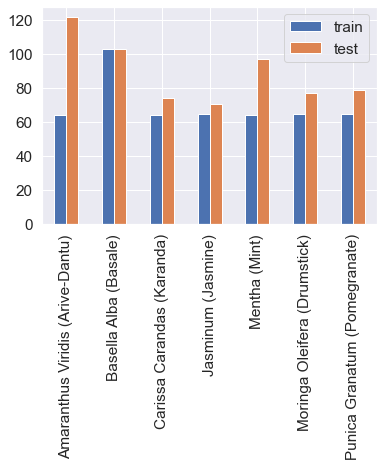

In [9]:
#visualizing the training and testing split
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

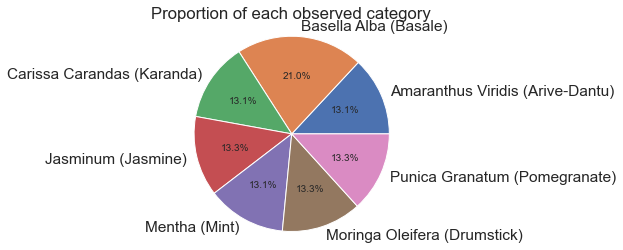

In [10]:
#data distribution
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [11]:
#scaling down the pixel values in the range 0 to 255 down to 0 to 1 
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [33]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1,1), activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(filters = F2, kernel_size = (f,f), activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv2D(filters = F3, kernel_size = (1,1), activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [34]:
def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1,1), activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(F2, (f,f), activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv2D(F3, (1,1), strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv2D(F3, (1,1), strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [41]:
def ResNet50(input_shape = (150,150.3)):
    
    X_input = Input(input_shape)

    X = ZeroPadding2D(3)(X_input)
    
    X = Conv2D(64, (7,7), activation='relu', strides = 2)(X)
    X = BatchNormalization()(X)
    X = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(7,activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [42]:
resNet50_model = ResNet50(input_shape = (150,150,3))

In [43]:
#comiling the neural network model
resNet50_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
history = resNet50_model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Train on 392 samples, validate on 98 samples
Epoch 1/20
392/392 [==============================] - ETA: 0s - loss: 8.7742 - acc: 0.1582WARNING:tensorflow:From C:\Users\91777\anaconda3\envs\reqd\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
392/392 [==============================] - 92s 236ms/sample - loss: 8.7742 - acc: 0.1582 - val_loss: 2.5241 - val_acc: 0.1224
Epoch 2/20
392/392 [==============================] - 104s 266ms/sample - loss: 13.0095 - acc: 0.1888 - val_loss: 6.0496 - val_acc: 0.1224
Epoch 3/20
392/392 [==============================] - 87s 223ms/sample - loss: 12.7820 - acc: 0.1990 - val_loss: 10.9195 - val_acc: 0.1224
Epoch 4/20
392/392 [==============================] - 81s 205ms/sample - loss: 13.4184 - acc:

In [47]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["acc"]
  val_accuracy = history.history["val_acc"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

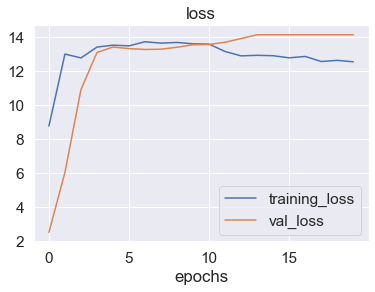

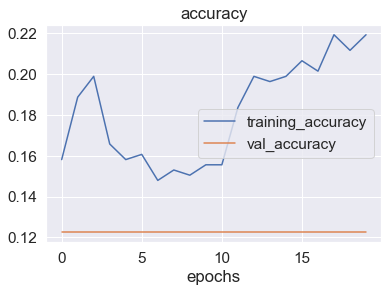

In [48]:
plot_loss_curves(history)